In [83]:

import tensorflow as tf
import deepxde as dde
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm, lognorm
import xarray as xr
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import pandas as pd

dde.config.set_default_float("float32")


Set the default float type to float32


In [84]:
import warnings

warnings.filterwarnings("ignore")

In [85]:
# Configurazioni e percorsi
# Configurazioni e percorsi
FIGURE_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Code/figures/"
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
INPUT_MODEL_PATH = DATA_PATH + "processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "trained_models/"
RESULTS_PATH = DATA_PATH + "model_results/"
path_to_shapefile = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)

In [86]:
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [87]:
df_simulated_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_simulation_Holocene.csv")
#df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")

df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])

latitude_wind, mean_wind = df_wind['latitude'].values / 90, df_wind['wind'].values / df_wind['wind'].max()


def wind_latitude(latitude):
    interpolated = wind_tf_interp(latitude, tf.convert_to_tensor(latitude_wind), tf.convert_to_tensor(mean_wind))
    return interpolated


tf_wind_latitude = tf.function(wind_latitude)


In [88]:
# creo una griglia 1°x1°
# Definisci i range
lon_vals = np.arange(-180, 181, 1)  # Include 180
lat_vals = np.arange(-90, 91, 1)    # Include 90

# Crea la griglia con tutti i punti (lon, lat)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Crea il DataFrame
df_global_grid_1x1 = pd.DataFrame({
    'lon': lon_flat,
    'lat': lat_flat
})

print(f"Griglia creata con {len(df_global_grid_1x1)} punti")

# Opzionale: salva su CSV
 #df_global_grid_1x1.to_csv("global_grid_1x1.csv", index=False)


Griglia creata con 65341 punti


In [89]:
def training_points(df):
    data_observ_points = dde.data.DataSet(
        X_train=df[['lon', 'lat']].values / 90,
        y_train=df['log_dep_norm'].values.reshape(-1, 1),
        X_test=df[['lon', 'lat']].values / 90,
        y_test=df['log_dep_norm'].values.reshape(-1, 1),
        standardize=False)

    observe_u = dde.icbc.PointSetBC(data_observ_points.train_x,
                                    df['log_dep_norm'].values.reshape(-1, 1), component=0)

    return data_observ_points, observe_u

In [90]:
x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

left_corner = np.array([x_min, y_min])  # xmin, ymin – Coordinate of bottom left corner.
right_corner = np.array([x_max, y_max])  # xmax, ymax – Coordinate of top right corner.
geometry_rectangle = dde.geometry.geometry_2d.Rectangle(left_corner, right_corner)

# Reduce the training domain to avoid pole singularities.
df_simulated_Holocene_2 = df_simulated_Holocene[
    (df_simulated_Holocene['lat'] >= -81) & (df_simulated_Holocene['lat'] <= 81)]


In [91]:
def pde(x, u):
    du_x = dde.grad.jacobian(u, x, j=0)  # du/dlambda
    du_y = dde.grad.jacobian(u, x, j=1)  # du/dtheta

    K = wind_latitude(x[:, 1:2])
    K = tf.cast(K, tf.float32)

    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # d^2u/dlambda^2
    du_yy = dde.grad.hessian(u, x, i=1, j=1)  # d^2u/dtheta^2

    return (
        (-K * du_x * (1 / tf.cos(x[:, 1:2] * np.pi / 2)) + D * (
        (1 / (tf.cos(x[:, 1:2] * np.pi / 2) ** 2) * du_xx + du_yy - tf.tan(x[:, 1:2] * np.pi / 2) * du_y)))
    )

In [92]:
def space_boundary_north(x, on_boundary):
    return on_boundary and np.isclose(y_max, x[1])


def space_boundary_south(x, on_boundary):
    return on_boundary and np.isclose(y_min, x[1])


def periodic_boundary(x, domain):
    return domain and (np.isclose(x[0], x_min) or np.isclose(x[0], x_max))

In [93]:
def train_process(data_observ_points, observe_u, D, bc_1, bc_2, model_name):
    data = dde.data.PDE(
        geometry_rectangle,
        pde,
        [observe_u, periodic_condition, periodic_condition_derivative, bc_1, bc_2],
        num_domain=2592,
        num_boundary=216,
        anchors=data_observ_points.train_x,
        train_distribution='uniform'
    )

    neurons = 64
    layer = 6
    layer_size = [2] + [neurons] * layer + [1]
    activation = "selu"
    initializer = "Glorot normal"
    net = dde.maps.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1e-20, maxiter=1e5)
    model.compile("adam", lr=0.00001, external_trainable_variables=[D, north_mean, south_mean],
                  loss_weights=[1, 10, 0.5, 0.5, 1, 1])

    # Train and save the model
    import os
    os.makedirs(MODEL_SAVE_PATH + model_name, exist_ok=True)

    checkpointer = dde.callbacks.ModelCheckpoint(
        f"{MODEL_SAVE_PATH}{model_name}/{model_name}.ckpt",
        verbose=0, period=10000,
    )

    variable = dde.callbacks.VariableValue([D, north_mean, south_mean], period=10000,
                                           filename=MODEL_SAVE_PATH + model_name + "/variables.dat")

    losshistory, train_state = model.train(epochs=15000, callbacks=[variable, checkpointer])
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)
    params = variable.get_value()

    return model, params, train_state.best_step, losshistory

In [94]:
north_mean = dde.Variable(-1.0)
south_mean = dde.Variable(-2.0)
D = dde.Variable(1.0)

bc_1 = dde.DirichletBC(geometry_rectangle, lambda x: north_mean, space_boundary_north)
bc_2 = dde.DirichletBC(geometry_rectangle, lambda x: south_mean, space_boundary_south)

periodic_condition = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0, on_boundary=periodic_boundary,
                                         derivative_order=0)
periodic_condition_derivative = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0,
                                                    on_boundary=periodic_boundary, derivative_order=1)


In [95]:


# Numero di strisce in cui dividere la regione
n_strisce = 18

# Estremi latitudinali della regione
lat_min, lat_max = -90,90
lon_min, lon_max = -180 ,180
# Calcolo gli estremi delle strisce (n_strisce+1 punti di divisione)
lon_bands = np.linspace(lon_min, lon_max, n_strisce + 1)

print("Limiti delle strisce longitudinali:", lon_bands)



Limiti delle strisce longitudinali: [-180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.   40.
   60.   80.  100.  120.  140.  160.  180.]


In [96]:
def assign_band(lon):
    for i in range(n_strisce):
        if lon_bands[i] <= lon < lon_bands[i + 1]:
            return i
    if lon == lon_bands[-1]:
        return n_strisce - 1

# Assegna la striscia a ogni punto
df_simulated_Holocene_2['lon_band'] = df_simulated_Holocene_2['lon'].apply(assign_band)

In [97]:
train_bands = [0, 1, 3, 4,  5, 7, 8, 9, 11 , 12, 13, 15 , 16 ,17 ]
test_bands = [ 2, 6, 10,  14]

df_train = df_simulated_Holocene_2[df_simulated_Holocene_2['lon_band'].isin(train_bands)]
df_test = df_simulated_Holocene_2[df_simulated_Holocene_2['lon_band'].isin(test_bands)]

print(f"Punti train: {len(df_train)}, punti test: {len(df_test)}")


Punti train: 38528, punti test: 11008


Compiling model...
Building feed-forward neural network...
'build' took 0.713070 s

'compile' took 10.441592 s

Training model...

0         [2.61e+01, 1.97e+01, 2.77e-01, 1.33e-01, 2.14e-01, 6.03e+00]    [2.61e+01, 1.97e+01, 2.77e-01, 1.33e-01, 2.14e-01, 6.03e+00]    []  
1000      [2.18e+00, 3.62e+00, 4.51e-02, 1.70e-01, 1.57e+00, 8.96e-01]    [2.18e+00, 3.62e+00, 4.51e-02, 1.70e-01, 1.57e+00, 8.96e-01]    []  
2000      [1.44e+00, 2.95e+00, 3.18e-02, 2.08e-01, 1.38e+00, 5.90e-01]    [1.44e+00, 2.95e+00, 3.18e-02, 2.08e-01, 1.38e+00, 5.90e-01]    []  
3000      [1.09e+00, 2.52e+00, 3.19e-02, 2.18e-01, 1.16e+00, 4.66e-01]    [1.09e+00, 2.52e+00, 3.19e-02, 2.18e-01, 1.16e+00, 4.66e-01]    []  
4000      [9.42e-01, 2.25e+00, 3.19e-02, 1.88e-01, 8.82e-01, 3.88e-01]    [9.42e-01, 2.25e+00, 3.19e-02, 1.88e-01, 8.82e-01, 3.88e-01]    []  
5000      [8.16e-01, 1.93e+00, 2.92e-02, 1.95e-01, 5.90e-01, 3.13e-01]    [8.16e-01, 1.93e+00, 2.92e-02, 1.95e-01, 5.90e-01, 3.13e-01]    []  
6000      [

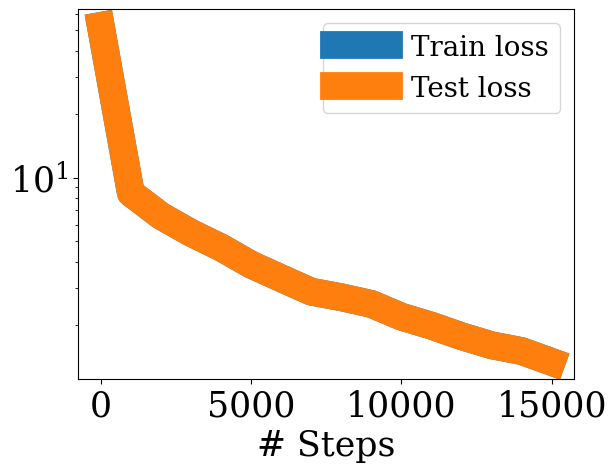

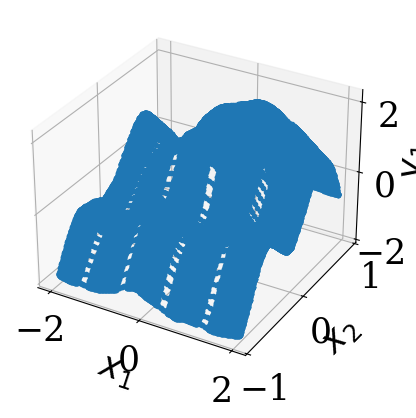

PINN MSE sulla regione: 0.1028


In [98]:
# Addestramento PINN e stima errori
# --------------------------------------------------

data_obs, bc_point = training_points(df_train)
pinn_model, _, _,losshistory = train_process(data_obs, bc_point, D, bc_1, bc_2, 'model_region')
Xg = (df_test[['lon', 'lat']].values / 90.0).astype(np.float32)
Yg = df_test['log_dep_norm'].values.reshape(-1, 1).astype(np.float32)
pinn_g = pinn_model.predict(Xg)
mse_pinn = np.mean((pinn_g - Yg) ** 2)
print(f"PINN MSE sulla regione: {mse_pinn:.4f}")



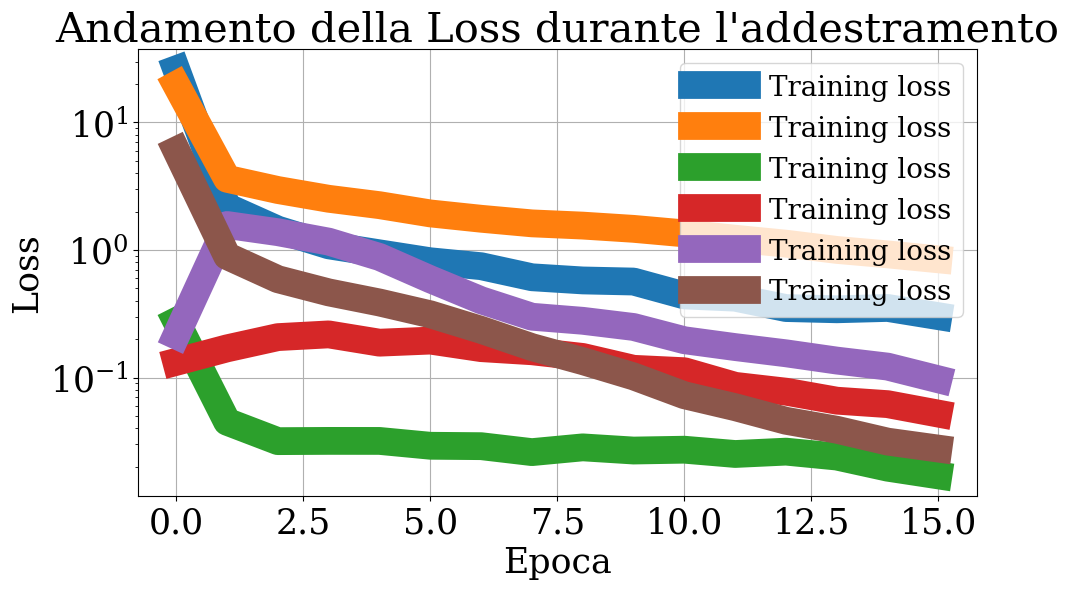

In [99]:
import matplotlib.pyplot as plt

# Estrai le epoche
epochs = range(len(losshistory.loss_train))

# Loss totale durante il training
plt.figure(figsize=(10, 6))
plt.plot(epochs, losshistory.loss_train, label="Training loss")

# Se disponibile: validation loss
#if losshistory.loss_test:
#   plt.plot(epochs, losshistory.loss_test, label="Test loss")

plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.title("Andamento della Loss durante l'addestramento")
plt.yscale("log")  # utile se le loss coprono più ordini di grandezza
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.875407859863995
Full Sill: 0.8754078704223858
Range: 101.08532352084002
Nugget: 1.0558390745293452e-08 



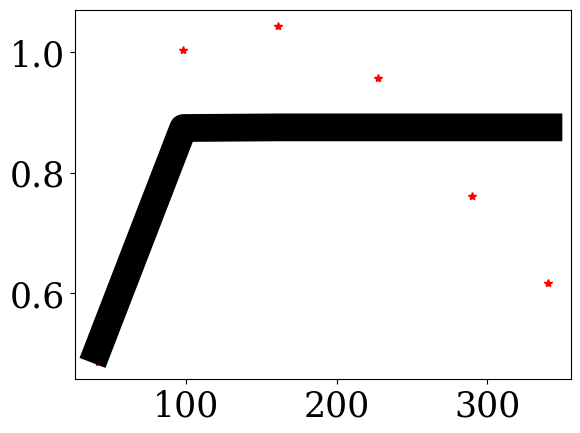

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Kriging MSE con 50 punti per striscia: 0.0414


In [100]:
# Kriging vettorializzato e stima errori
# --------------------------------------------------
# seleziono 50 punti da ogni striscia
# Campiona 50 punti casuali da ciascuna striscia di training
df_train_sampled = (
    df_train.groupby('lon_band')
    .apply(lambda g: g.sample(n=min(100, len(g)), random_state=42))
    .reset_index(drop=True))

# Coordinate e valori da usare per il Kriging
lon_tr = df_train_sampled['lon'].values
lat_tr = df_train_sampled['lat'].values
val_tr = df_train_sampled['log_dep_norm'].values

# Inizializza il modello Kriging
ok = OrdinaryKriging(
    lon_tr, lat_tr, val_tr,
    variogram_model='spherical', verbose=True, enable_plotting=True)
# Esegui la predizione
krig_arr, _ = ok.execute(
    'points',
    df_test['lon'].values,
    df_test['lat'].values)
# Calcola MSE

krig_g = krig_arr.reshape(-1, 1)
Yg = df_test['log_dep_norm'].values.reshape(-1, 1)
mse_krig = np.mean((krig_g - Yg) ** 2)
print(f"Kriging MSE con 50 punti per striscia: {mse_krig:.4f}")




In [101]:
for b in test_bands:
    print(f"Banda {b} da {lon_bands[b]} a {lon_bands[b+1]}")



Banda 2 da -140.0 a -120.0
Banda 6 da -60.0 a -40.0
Banda 10 da 20.0 a 40.0
Banda 14 da 100.0 a 120.0


In [102]:
with open("functions_plot_calculations.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [128]:
def calculate_save_df(model, df_to_predict, mean, std, path, filename):
    "Perform the predictions and save the results."
    U_pred = model.predict(df_to_predict[['lon', 'lat']].values / 90)
    U_pred_denorm = (U_pred *std ) +mean
    df_to_predict['PINN_log_dep'] = U_pred_denorm
    df_to_predict.to_csv(path + filename, index=False)


def calculate_save_kriging_df(ok_model, df_to_predict, path, filename):
    """
    Esegue la predizione con Kriging su df_to_predict e salva il risultato.
    ok_model: oggetto OrdinaryKriging già addestrato
    df_to_predict: DataFrame con colonne 'lon' e 'lat'
    """
    # Esegui predizione (già in scala originale)
    krig_arr, _ = ok_model.execute('points', df_to_predict['lon'].values, df_to_predict['lat'].values)

    # Aggiungi la colonna al DataFrame (senza denormalizzazione!)
    df_to_predict['Kriging_log_dep'] = krig_arr

    # Salva il risultato
    df_to_predict.to_csv(path + filename, index=False)


mean = df_simulated_Holocene['log_dep'].mean()
std = df_simulated_Holocene['log_dep'].std()

calculate_save_df(pinn_model, df_test, mean, std, RESULTS_PATH, "df_pinn_simulated_bands.csv")
calculate_save_df(pinn_model, df_global_grid_1x1, mean, std, RESULTS_PATH, "df_pinn_prediction_grid_1x1.csv")
calculate_save_kriging_df(ok, df_test, RESULTS_PATH, "df_kriging_simulated_bands.csv")


Executing Ordinary Kriging...



In [130]:
df_pinn_simulated_bands=pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_pinn_simulated_bands.csv")
df_pinn_prediction_grid_1x1=pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_pinn_prediction_grid_1x1.csv")
df_kriging_simulated_bands=pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_kriging_simulated_bands.csv")

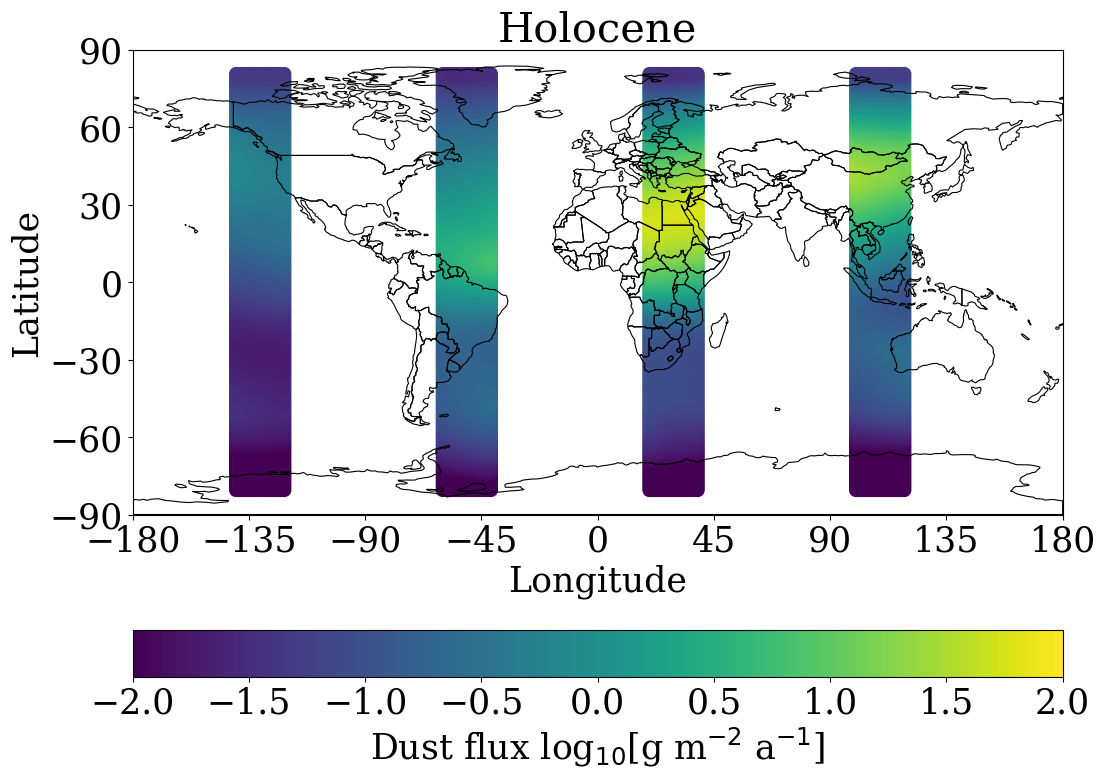

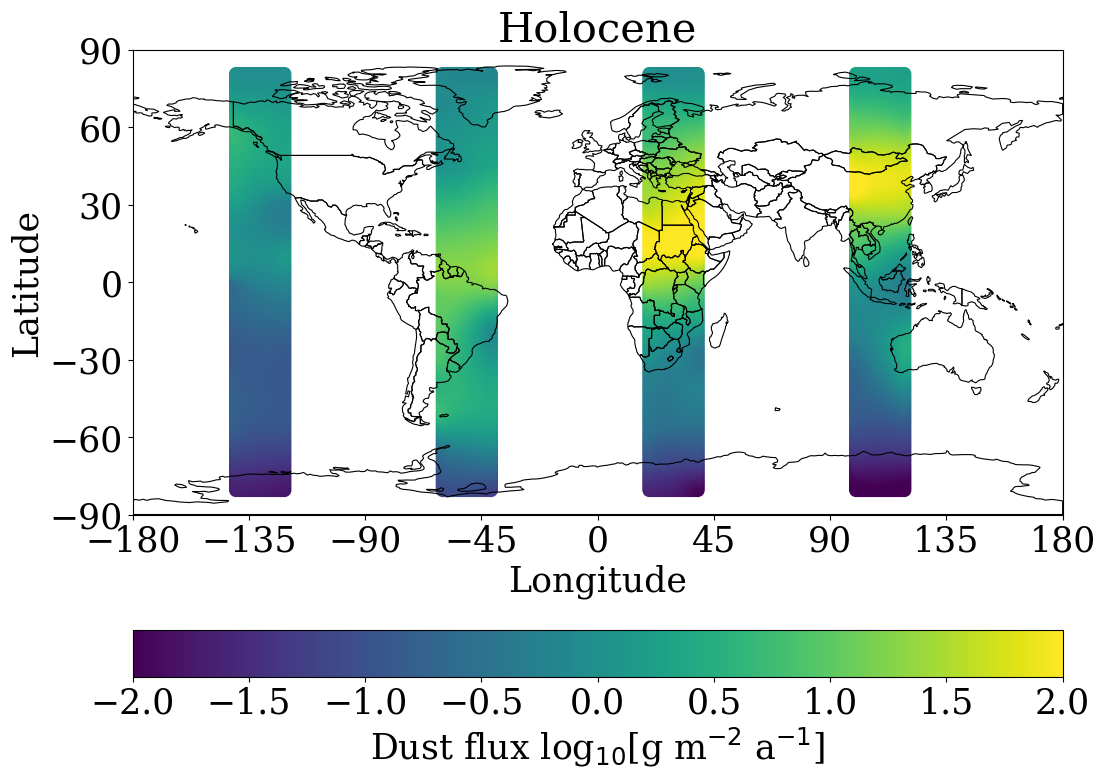

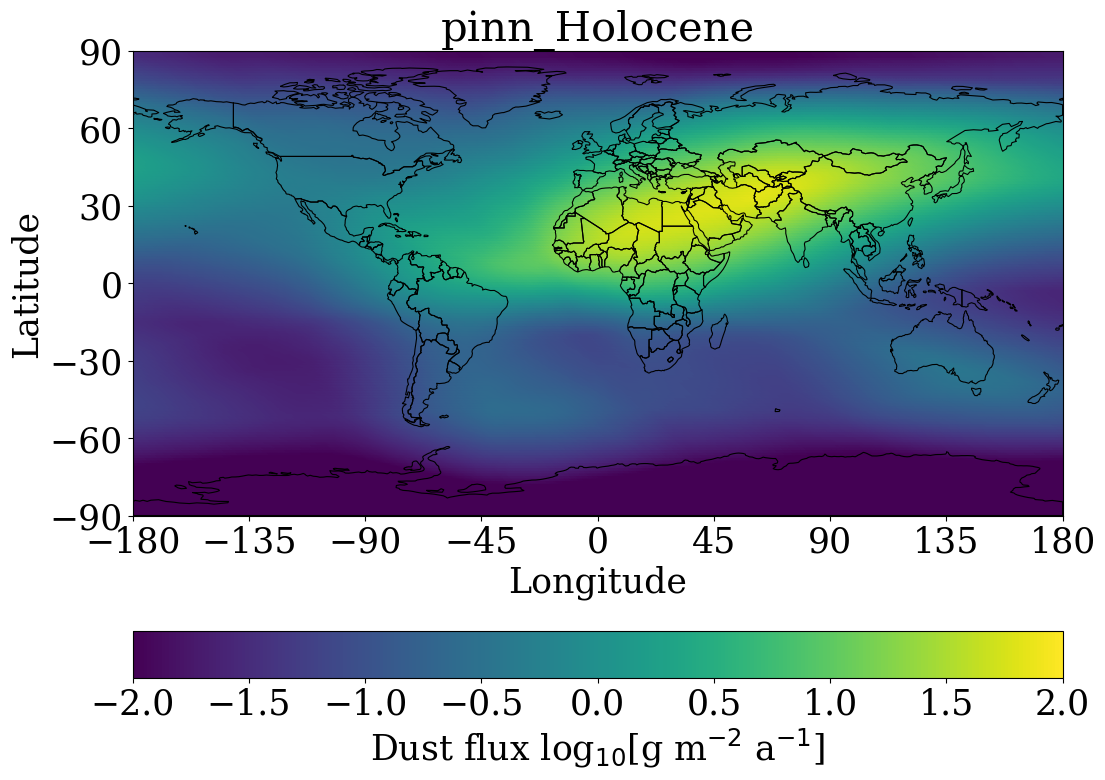

In [131]:
plot_dust_deposition_simulated(

    df=df_pinn_simulated_bands,
    title='Holocene',
    name_to_save='PINN_MAP_SIMULATED_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2,

)

plot_dust_deposition_simulated(
    df=df_kriging_simulated_bands,
    title='Holocene',
    name_to_save='PINN_MAP_SIMULATED_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='Kriging_log_dep',
    limit_bar=2,

)
plot_dust_deposition_simulated(
    df=df_pinn_prediction_grid_1x1,

    title='pinn_Holocene',
    name_to_save='PINN_MAP_grid1x1_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2,

)

In [126]:
import pandas as pd

# Calcoliamo i minimi e i massimi per le colonne log_dep e log_dep_norm
log_dep_min = df_simulated_Holocene['log_dep'].min()
log_dep_max = df_simulated_Holocene['log_dep'].max()

log_dep_norm_min = df_simulated_Holocene['log_dep_norm'].min()
log_dep_norm_max = df_simulated_Holocene['log_dep_norm'].max()

# Visualizziamo i risultati
print(f"Min log_dep: {log_dep_min}, Max log_dep: {log_dep_max}")
print(f"Min log_dep_norm: {log_dep_norm_min}, Max log_dep_norm: {log_dep_norm_max}")


Min log_dep: -3.10527406627821, Max log_dep: 3.358718196108388
Min log_dep_norm: -2.1998328352556267, Max log_dep_norm: 3.637481781836515


In [127]:
# Verifica la normalizzazione Min-Max
df_simulated_Holocene['log_dep_norm_computed'] = (
    df_simulated_Holocene['log_dep'] - log_dep_min) / (log_dep_max - log_dep_min)

# Calcola la differenza tra log_dep_norm e log_dep_norm_computed
df_simulated_Holocene['difference'] = df_simulated_Holocene['log_dep_norm'] - df_simulated_Holocene['log_dep_norm_computed']

# Visualizza le prime righe per vedere se la normalizzazione coincide
print(df_simulated_Holocene[['log_dep', 'log_dep_norm', 'log_dep_norm_computed', 'difference']].head())


    log_dep  log_dep_norm  log_dep_norm_computed  difference
0 -2.612779     -1.755085               0.076191   -1.831275
1 -2.613904     -1.756100               0.076017   -1.832117
2 -2.616180     -1.758156               0.075664   -1.833820
3 -2.616759     -1.758679               0.075575   -1.834254
4 -2.612491     -1.754825               0.076235   -1.831060
